In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, HDFStore
import matplotlib.pyplot as plt
import datetime as dt
import sqlite3
import pandas_datareader.data as web

import quandl as ql

In [2]:
# main       = HDFStore('database/main.h5')
# currencies = main['currencies']
# xetra      = main['xetra']

cnx        = sqlite3.connect('database/stocks_main.db')
xetra      = pd.read_sql("SELECT * FROM XETRA;", cnx)
currencies = pd.read_sql("SELECT * FROM currencies", cnx)

In [55]:
def get_datetime(inputobj):
    return dt.datetime.date(inputobj)

def convert_sql_date_to_datetime_date(string):
    return dt.datetime.strptime(string,'%Y-%m-%d').date()

class quotes:
    def __init__(self):
        pass

    def _extract_unsaved_rows(self):
        # give back the rows of the loaded stock quote which are not in the database

        # load the entries for the current stock from the database
        cnx         = sqlite3.connect('database/stocks_quotes.db')
        sql         = pd.read_sql_query("SELECT * FROM quotes;", cnx)
        cnx.close()
        
        sql['date'] = sql.date.apply(convert_sql_date_to_datetime_date)

        # remove the intersection of the saved and the loaded quote
        df = pd.merge(sql, self.quote, how='right', indicator=True)
        df = df[df['_merge']!='both']
        df = df.drop('_merge', 1)
        if self.verbose:
            print("Stock {0}, found {1} rows to add".format(self.name,len(df)))
        return df

    def _get_quote_quandl(self):
        isin, ticker = self.isin, self.ticker
        
        if isin[0:2]=='DE':
            prefix = "FSE/"
            suffix = "_X"
            key = "{0}{1}{2}".format(prefix,ticker,suffix)
            df  = ql.get(key, authtoken="CkyBkkkbzfh3ePfDF_ip")
            df  = df[['Open','High','Low','Close','Traded Volume']]
            df.columns = ['Open','High','Low','Close','Volume'] 
            self.quote_exchange = 'FSE'
            self.quote_currency = 'EUR'
            
        elif isin[0:2]=='CH':
            key = "SIX/{0}CHF1".format(self.isin)
            self.quote_exchange = 'SIX'
            self.quote_currency = 'CHF'            
            df  = ql.get(key, authtoken="CkyBkkkbzfh3ePfDF_ip")            
            df.columns = ['Close','Volume']  
            
        elif isin[0:2]=='US':
            df = ql.get_table('WIKI/PRICES',
                              ticker=ticker, 
                              paginate=True, 
                              authtoken="CkyBkkkbzfh3ePfDF_ip")
            self.quote_exchange = 'NYSE'
            self.quote_currency = 'USD'            
            df = df[['date','open','high','low','close','volume']]
            df.columns = ['Date','Open','High','Low','Close','Volume']
            
        if 'Date' not in df.index:
            df.reset_index(level=0, inplace=True)
            
        return df
        
    def _get_quote_google(self):
        isin   = self.isin
        ticker = self.ticker
        
        if isin[0:2]=='DE':
            prefix="FRA:"
            self.quote_currency = 'EUR'            
        elif isin[0:2]=='CH':
            self.quote_currency = 'EUR'            
            prefix="SIX"
        elif isin[0:2]=='US':
            self.quote_currency = 'USD'
            prefix='NYSE'
        else:
            return
        self.quote_exchange = prefix

        start = dt.datetime(1900, 1, 1)
        end   = dt.datetime.today()
            
        key = "{0}{1}".format(prefix,ticker)
        df  = web.DataReader(key, 'google', start, end)
        
        if 'Date' not in df.index:
            df.reset_index(level=0, inplace=True)        
        
        return df
        
    def _get_quote_yahoo(self,verbose=False):
        ISIN, ticker = self.isin, self.ticker
        
        key      = ISIN[0:2]

        exchange       = {}
        exchange['AT'] = ['.DE', '.F', '.SG','.BE']
        exchange['DE'] = ['.DE', '.F', '.SG','.BE']
        exchange['US'] = ['']
        exchange['CH'] = ['.VX','.F','.DE']
        exchange['GB'] = ['.F']
        exchange['AU'] = ['.DE', '.F',  '.SG','.BE']
        exchange['FR'] = ['.PA', '.DE', '.F', '.SG','.BE']
        exchange['JP'] = ['.DE', '.F',  '.SG','.BE']

        currency = {'.DE': 'EUR', '':'USD',  '.F':'EUR', '.VX':'CHF', '.SG':'EUR', '.PA':'EUR', '.BE':'EUR'}

        start = dt.datetime(1900, 1, 1)
        end   = dt.datetime.today()    

        df1 = {}

        for e in exchange[key]:
            for i in range(1,6): # try multiple times, 
                try:
                    df1[e] = web.DataReader("{0}{1}".format(ticker,e), 'yahoo', start, end)
                    ex  = e
                    if verbose:
                        print('Successfully loaded quote for {0} from yahoo, exchange {1}'.format(ISIN,ex))
                    break
                except:
                    if verbose:
                        print('Trials to load {0} quote: {1}/5'.format("{0}{1}".format(ticker,e),i))
                    continue

        df = []
        ex = ''
        for e in df1.keys():
            if len(df1[e])>len(df):
                df = df1[e]
                ex = e
        
        self.quote_exchange = ex
        self.quote_currency = currency[ex]

        if len(df)==0:
            return None

        if 'Date' not in df.index:
            df.reset_index(level=0, inplace=True)

        df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

        return df
    
    def _find_splits(self):
        relchange   = self.quote.Close.diff()/self.quote.Close
        self.splits = (relchange[relchange<-0.5]*(-1)+ 1).round()

        for i,splitdate in enumerate(self.quote.loc[self.splits.index].Date):
            self.quote.loc[self.quote.Date < 
                        splitdate,'Close'] = self.quote.loc[self.quote.Date < 
                                                         splitdate,'Close']/np.array(self.splits)[i]        
    def _prepare_for_saving(self):
        if self.quote is None:
            return
        
        # find columns which are not in the dataframe and replace them with zeros
        for _col in ['Date','Open','High','Low','Close','Volume']:
            if _col not in self.quote.columns:
                self.quote = self.quote.assign(**{_col:pd.Series(np.zeros(len(self.quote))).values})
                
        # add columns with the name and isin of the stock
        self.quote = self.quote.assign(name=pd.Series([self.name for _ in range(len(self.quote))]))
        self.quote = self.quote.assign(isin=pd.Series([self.isin for _ in range(len(self.quote))]))
        self.quote = self.quote.assign(currency=pd.Series([self.quote_currency for _ in range(len(self.quote))]))
        self.quote = self.quote.assign(exchange=pd.Series([self.quote_exchange for _ in range(len(self.quote))]))
                
        # re-order the elements
        self.quote = self.quote[['Date','name','isin','exchange',
                                 'currency','Open','High','Low','Close','Volume']]
        
        # re-name the elements
        self.quote.columns = ['date','name','isin','exchange','currency','open',
                              'high','low','close','volume']
        
        # put date in the correct format
        self.quote['date'] = self.quote['date'].apply(get_datetime)
        
        # produce the saveable object
        self.quote_to_save = self._extract_unsaved_rows()
        
    def _save_in_sql(self):
        if len(self.quote_to_save)==0:
            return
        
        cnx         = sqlite3.connect('database/stocks_quotes.db')
        self.quote_to_save.to_sql('quotes',cnx,if_exists='append',index=False)
        cnx.close()
        
        
    def get_quote(self, find_splits=True, download=True):
        
        if not download:
            # load the entries for the current stock from the database
            cnx         = sqlite3.connect('database/stocks_quotes.db')
            self.quote  = pd.read_sql_query("SELECT * FROM quotes WHERE ISIN = '{0}';".format(self.isin), cnx)
            cnx.close()
            self.quote['date'] = self.quote.date.apply(convert_sql_date_to_datetime_date)
            return
        
        
        success_quandl = False
        success_yahoo  = False
        
        # load quote from quandl
        try:
            quote_quandl   = self._get_quote_quandl()
            if quote_quandl is not None:
                success_quandl = True
        except:
            pass

        # load quote from yahoo
        try:
            quote_yahoo   = self._get_quote_yahoo()
            if quote_yahoo is not None:
                success_yahoo = True
        except:
            pass 
        
        # if neither of them worked load from google
        
        if not success_quandl and not success_yahoo:
            quote         = self._get_quote_google()
        else:
            if success_quandl and success_yahoo:
                if len(quote_quandl) > len(quote_yahoo):
                    quote = quote_quandl
                else:
                    quote = quote_yahoo
            elif success_quandl and not success_yahoo:
                quote = quote_quandl
            elif not success_quandl and success_yahoo:
                quote = quote_yahoo
        
        # assign the quote 
        self.quote = quote
        
        if not find_splits:
            return
        
        try:
            self._find_splits()
        except AttributeError:
            self.quote = None
            pass
        
        self._prepare_for_saving()
        self._save_in_sql()

In [56]:
class stocks(quotes):
    def __init__(self,stocklist,index=0,ISIN=None,verbose=False):
        self.list    = stocklist
        self.verbose = verbose

        if ISIN:
            self.switch_isin(ISIN)
        else:
            self.switch_index(index)
        self._update_tables()
        
    def switch_isin(self,isin):
        df         = self.list[self.list.ISIN==isin]
        self.index = df.index[0]
        self.name, self.isin, self.ticker = np.array(df)[0]
        self._update_tables()
        
    def switch_index(self,index):
        self.index = index
        df         = self.list[self.list.index==index]
        self.name, self.isin, self.ticker = np.array(df)[0]
#         self._update_tables()
        
    def switch_next(self):
        try:
            self.switch_index(self.index+1)
            self._update_tables()
            self.quote = None
        except IndexError:
            pass

    def _update_tables(self):
        try:
            self.load_keyratios('ms_keyratios/'+self.ticker+'.csv')
        except:
            self.keyratios = None

## Load quote for one stock

Requirements:
1. Check if entry already exists in database
2. Only add entry if it didnt exist before

In [60]:
s = stocks(xetra,verbose=True)
s.switch_isin('DE0005790430')
s.get_quote(find_splits=True,download=False)

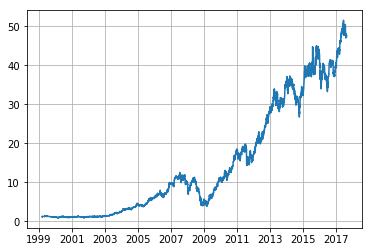

In [61]:
plt.plot(s.quote.date,s.quote.close)
plt.grid()
plt.show()

In [ ]:
s = stocks(xetra,verbose=True)
s.switch_isin('DE0001218063')

while True:
    s.get_quote(find_splits=True, download=True)
    s.switch_next()
    if s.isin=='DE000ZAL1111':
        break